In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/drug-classification/drug200.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')

# Exploratory Data Analysis

In [5]:
data.shape

(200, 6)

In [6]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [7]:
data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [8]:
data.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

No missing or null values in data

200 data variables and 6 features(including the label)

## Feature analysis

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## Age:
### Age of the patient

In [10]:
print('Maximum age:',max(data['Age']))
print('Minimum age:',min(data['Age']))

Maximum age: 74
Minimum age: 15


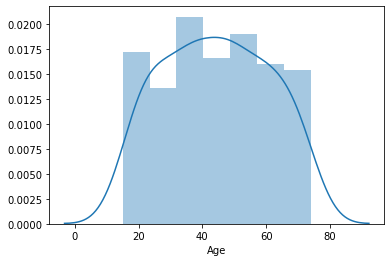

In [11]:
sb.distplot(data['Age'])

Age ranges from 15 to 74

## Sex:
### Sex of the patient

In [12]:
data.Sex.value_counts()

M    104
F     96
Name: Sex, dtype: int64

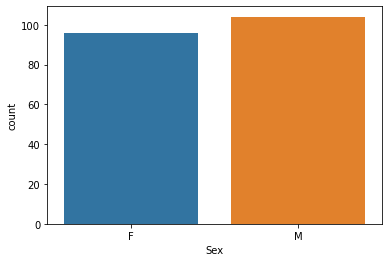

In [13]:
sb.countplot(x = data.Sex)

Sex ratio seems to be balanced.

Since it is a categorical variable, we convert it to numeric using label encoder in python

## BP:

### Blood Pressure of patient

In [14]:
data.BP.value_counts()

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

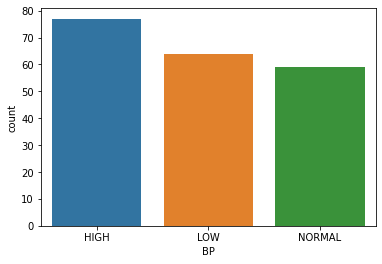

In [15]:
sb.countplot(x = data.BP)

BP ratio seems to be balanced.

Since it is a categorical variable, we convert it to numeric using label encoder in python

## Cholesterol:
### Cholesterol of the patient

In [16]:
data.Cholesterol.value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

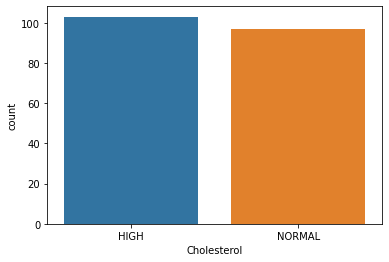

In [17]:
sb.countplot(x = data.Cholesterol)

Cholesterol ratio seems to be balanced.

Since it is a categorical variable, we convert it to numeric using label encoder in python

## Na_to_K:
### Sodium-Potassium ratio in patient's blood

In [18]:
print("Maximum Sodium-Potassium ratio:",data.Na_to_K.max())
print("Minimum Sodium-Potassium ratio:",data.Na_to_K.min())

Maximum Sodium-Potassium ratio: 38.247
Minimum Sodium-Potassium ratio: 6.269


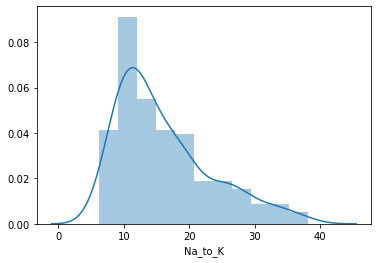

In [19]:
sb.distplot(data.Na_to_K)

Sodium-Potassium ratio ranges from 6.269 to 38.247

## Drug:
### Drug administered to the patient

In [20]:
data.Drug.value_counts()

DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64

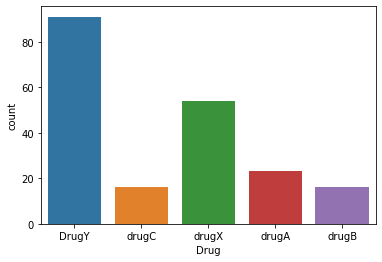

In [21]:
sb.countplot(data.Drug)

Drug is the target column(value) or label.

# Relationship between features and target value:

## Age - Drug

Text(0.5, 1.0, 'Age to Drug')

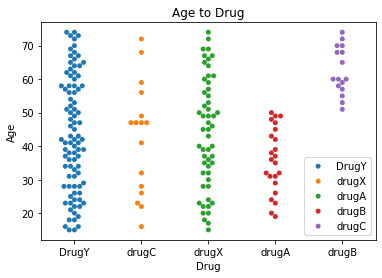

In [22]:
sb.swarmplot(x = "Drug", y = "Age",data = data)
plt.legend(data.Drug.value_counts().index)
plt.title("Age to Drug")

In [23]:
print("Maximum Age for administering Drug A:",data.Age[data.Drug == "drugA"].max())
print("Minimum Age for administering Drug B:",data.Age[data.Drug == "drugB"].min())

Maximum Age for administering Drug A: 50
Minimum Age for administering Drug B: 51


Drug A is administered to patients below 50 years.

Drug B is administered to patients above 51 years.

## Sex - Drug

Text(0.5, 1.0, 'Sex to Drug')

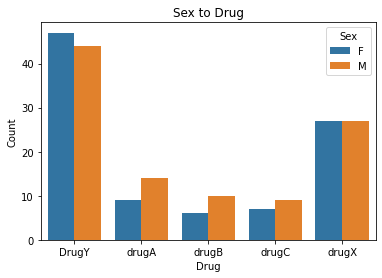

In [24]:
sex_drug = data.groupby(['Drug','Sex']).size().reset_index(name = 'Count')
sb.barplot(x = 'Drug',y = 'Count', hue = 'Sex', data = sex_drug)
plt.title('Sex to Drug')

From this graph, we find Sex is not an important feature for classification.

## BP - Drug

Text(0.5, 1.0, 'BP to Drug')

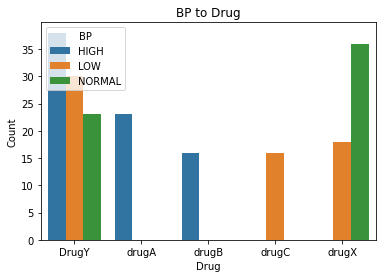

In [25]:
BP_drug = data.groupby(['Drug','BP']).size().reset_index(name = 'Count')
sb.barplot(x = 'Drug',y = 'Count', hue = 'BP', data = BP_drug)
plt.title('BP to Drug')

Drug A and Drug B is administered only for people who have HIGH blood pressure.

Drug C is administered only for people who have LOW blood pressure.

BP is an important feature for classification.

## Cholesterol - Drug

Text(0.5, 1.0, 'Cholesterol to Drug')

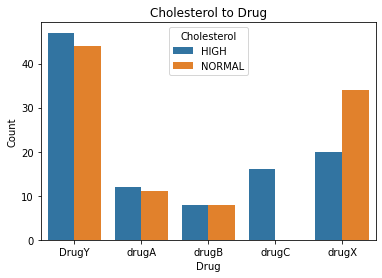

In [26]:
BP_drug = data.groupby(['Drug','Cholesterol']).size().reset_index(name = 'Count')
sb.barplot(x = 'Drug',y = 'Count', hue = 'Cholesterol', data = BP_drug)
plt.title('Cholesterol to Drug')

Drug C is only administered for patients with HIGH Cholesterol.

Cholesterol is important feature to classify Drug C.

## Na_to_K - Drug

Text(0.5, 1.0, 'Na_to_K - Drug')

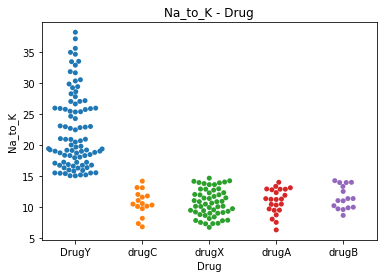

In [27]:
sb.swarmplot(x = "Drug", y = "Na_to_K",data = data)
plt.title("Na_to_K - Drug")

In [28]:
print("Minimum value of Na_to_K for Drug Y:",data.Na_to_K[data.Drug == "DrugY"].min())

Minimum value of Na_to_K for Drug Y: 15.015


People who have Na_to_K ratio is greater than 15, Drug Y is administered.

We can create a new feature from this feature for better classification of Drug Y.

# Data preprocessing:

## Feature Engineering

In [29]:
data['Na_to_K>15'] = np.where(data['Na_to_K'] > 15, 1, 0)

## Label Encoding

In [30]:
from sklearn import preprocessing 
label_encode = preprocessing.LabelEncoder() 

In [31]:
label_encode_list = ['Sex','BP','Cholesterol','Na_to_K>15','Drug']

for i in label_encode_list:
    data[i] = label_encode.fit_transform(data[i])

In [32]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K>15
0,23,0,0,0,25.355,0,1
1,47,1,1,0,13.093,3,0
2,47,1,1,0,10.114,3,0
3,28,0,2,0,7.798,4,0
4,61,0,1,0,18.043,0,1


# Train-Test split for the dataset

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
x = data.drop(['Drug'], axis = 1)
y = data.Drug

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)


In [36]:

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [37]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (160, 6)
x_test shape: (40, 6)
y_train shape: (160, 1)
y_test shape: (40, 1)


Dataset is split into training and test data in 4:1 ratio

# Model for the data

## KNN Classifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(x_train,y_train)
knnPred = knn.predict(x_test)

In [39]:
knn.score(x_test,y_test)

0.7

In [40]:
grid = {'n_neighbors':np.arange(1,120),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }
knn_cv = GridSearchCV(knn,grid,cv=5)
knn_cv.fit(x_train,y_train)
knnCvPred = knn_cv.predict(x_test)
knn_cv.score(x_test,y_test)


0.75

In [41]:
knn_cv.best_params_

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

## Decision Tree Classifier

In [42]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion = "entropy")
dt.fit(x_train, y_train)
dtPred = dt.predict(x_test)

In [43]:
dt.score(x_test,y_test)

1.0

In [44]:
grid = {'criterion':['gini','entropy'],'max_depth':np.arange(1,5)}
dt_cv = GridSearchCV(dt, grid, cv=5)
dt_cv.fit(x_train, y_train)
dtCvPred = dt_cv.predict(x_test)

In [45]:
print(dt_cv.best_params_)
dt_cv.score(x_test,y_test)

{'criterion': 'gini', 'max_depth': 4}


1.0

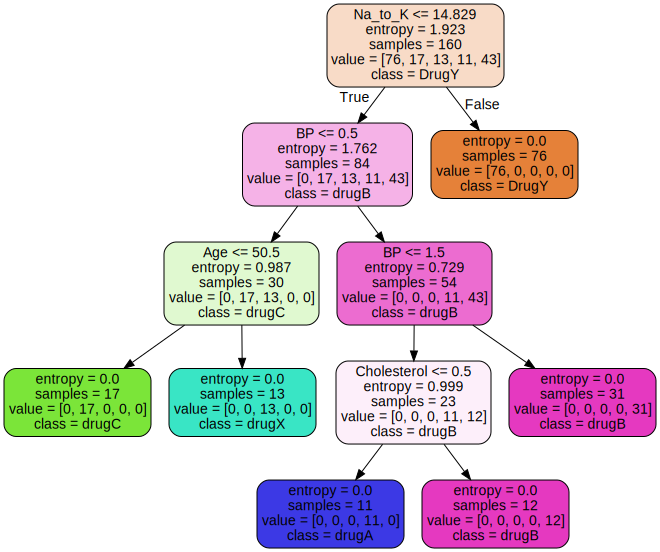

In [46]:
from sklearn.tree import export_graphviz
import graphviz

class_names = ['DrugY','drugC','drugX','drugA','drugB']
feature_names = ['Age','Sex','BP','Cholesterol','Na_to_K','Na_to_K>15']

dot_data = export_graphviz(dt, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(dot_data)  
graph     

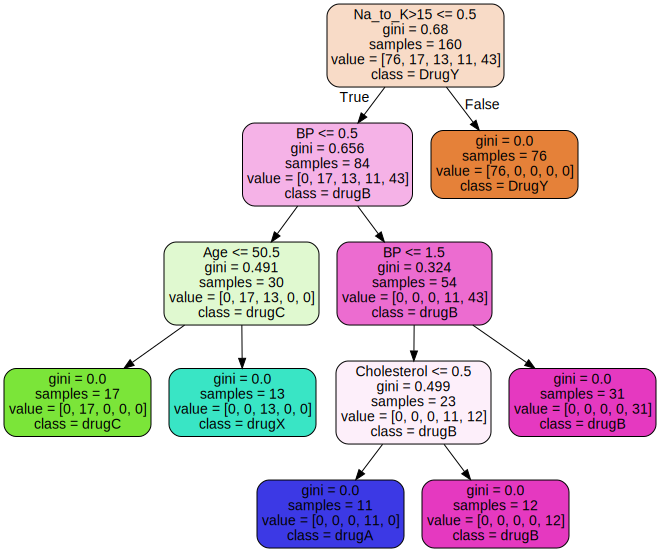

In [47]:
from sklearn.tree import export_graphviz
import graphviz

class_names = ['DrugY','drugC','drugX','drugA','drugB']
feature_names = ['Age','Sex','BP','Cholesterol','Na_to_K','Na_to_K>15']

dot_data = export_graphviz(dt_cv.best_estimator_, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(dot_data)  
graph     

## Random Forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)
rfcPred = rfc.predict(x_test)

In [49]:
print(np.mean(cross_val_score(rfc, x_train, y_train, cv=5)))
rfc.score(x_test,y_test)

0.98125


0.975

In [50]:
grid = {'n_estimators':np.arange(100,1000,100),
        'criterion':['gini','entropy'],
       }


rfc_cv = GridSearchCV(rfc, param_grid=grid, cv= 5)
rfc_cv.fit(x_train, y_train)
rfcCvPred = rfc_cv.predict(x_test)

In [51]:
print(rfc_cv.best_score_)
print(rfc_cv.best_params_)
print(rfc_cv.score(x_test,y_test))

0.9875
{'criterion': 'gini', 'n_estimators': 700}
0.975


# Performance metrics of Models


## Accuracy


### Without GSCV

In [52]:
acc_knn = knn.score(x_test,y_test)
acc_dt = dt.score(x_test,y_test)
acc_rfc = rfc.score(x_test,y_test)

In [53]:
print(acc_knn,acc_dt,acc_rfc)

0.7 1.0 0.975


### With GSCV

In [54]:
acc_cv_knn = knn_cv.score(x_test,y_test)
acc_cv_dt = dt_cv.score(x_test,y_test)
acc_cv_rfc = rfc_cv.score(x_test,y_test)

In [55]:
print(acc_cv_knn,acc_cv_dt,acc_cv_rfc)

0.75 1.0 0.975


### Confusion Matrix Plot

### Without GSCV


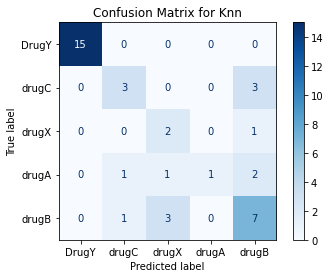

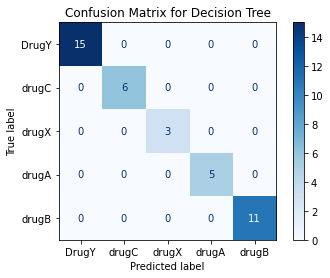

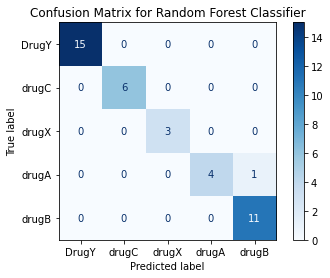

In [56]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
class_names = ['DrugY','drugC','drugX','drugA','drugB']

dispKnnConfMat = plot_confusion_matrix(knn, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
dispKnnConfMat.ax_.set_title('Confusion Matrix for Knn')

dispdtConfMat = plot_confusion_matrix(dt, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
dispdtConfMat.ax_.set_title('Confusion Matrix for Decision Tree')

disprfcConfMat = plot_confusion_matrix(rfc, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
disprfcConfMat.ax_.set_title('Confusion Matrix for Random Forest Classifier')
plt.show() 

### With GSCV

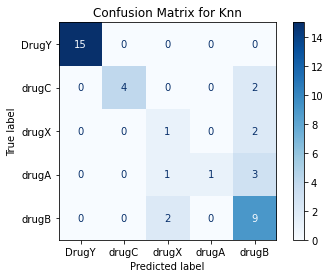

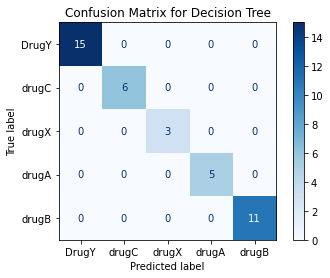

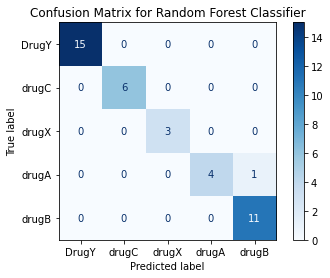

In [57]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
class_names = ['DrugY','drugC','drugX','drugA','drugB']

dispKnnConfMat = plot_confusion_matrix(knn_cv, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
dispKnnConfMat.ax_.set_title('Confusion Matrix for Knn')

dispdtConfMat = plot_confusion_matrix(dt_cv, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
dispdtConfMat.ax_.set_title('Confusion Matrix for Decision Tree')

disprfcConfMat = plot_confusion_matrix(rfc_cv, x_test, y_test,cmap=plt.cm.Blues,display_labels = class_names)
disprfcConfMat.ax_.set_title('Confusion Matrix for Random Forest Classifier')
plt.show() 

## Report

### Without GSCV

In [58]:
report_knn = metrics.classification_report(y_test, knnPred,target_names=class_names)
report_dt = metrics.classification_report(y_test, dtPred,target_names=class_names)
report_rfc= metrics.classification_report(y_test, rfcPred,target_names=class_names)
print(report_knn,report_dt,report_rfc,sep = '\n\n')

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugC       0.60      0.50      0.55         6
       drugX       0.33      0.67      0.44         3
       drugA       1.00      0.20      0.33         5
       drugB       0.54      0.64      0.58        11

    accuracy                           0.70        40
   macro avg       0.69      0.60      0.58        40
weighted avg       0.76      0.70      0.69        40


              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00         3
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


              precis

### with GSCV

In [59]:
report_knn = metrics.classification_report(y_test, knnCvPred,target_names=class_names)
report_dt = metrics.classification_report(y_test, dtCvPred,target_names=class_names)
report_rfc= metrics.classification_report(y_test, rfcCvPred,target_names=class_names)
print(report_knn,report_dt,report_rfc,sep = '\n\n')

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugC       1.00      0.67      0.80         6
       drugX       0.25      0.33      0.29         3
       drugA       1.00      0.20      0.33         5
       drugB       0.56      0.82      0.67        11

    accuracy                           0.75        40
   macro avg       0.76      0.60      0.62        40
weighted avg       0.82      0.75      0.74        40


              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00         3
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


              precis